# Projekt analiza danych na temat sepsy.


Projekt ma za zadanie przeanalizować dane zawarte na stronie https://archive.ics.uci.edu/ml/datasets/Sepsis+survival+minimal+clinical+records
Dataset zawiera informacje na temat płci, wieku, epizodu sepsy oraz czy pacjent przeżył.
W swojej pracy skupiam się na pokazaniu danych dotyczących umieralności na poszczególne etapy sepsy oraz ogólne informacje o
pacjentach. Na koniec przedstawiam prawdopodobieństwo śmierci pacjenta.
Projekt realizowany przez Mateusz Orski 235939 informatyka 5 semestr grupa EAIBD.


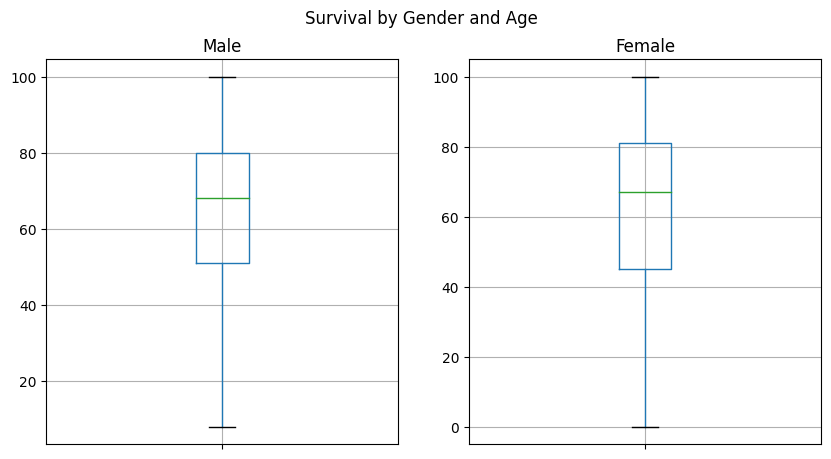

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data = pd.read_csv("s41598-020-73558-3_sepsis_survival_primary_cohort.csv")

male = data[data['sex_0male_1female'] == 0]
female = data[data['sex_0male_1female'] == 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Patients Alive')

male[male['hospital_outcome_1alive_0dead'] == 1].boxplot(column='age_years', ax=ax1, showfliers=False)
ax1.set_title('Male')
ax1.set_xticklabels([])

female[female['hospital_outcome_1alive_0dead'] == 1].boxplot(column='age_years', ax=ax2, showfliers=False)
ax2.set_title('Female')
ax2.set_xticklabels([])

fig.suptitle("Survival by Gender and Age")

plt.show()

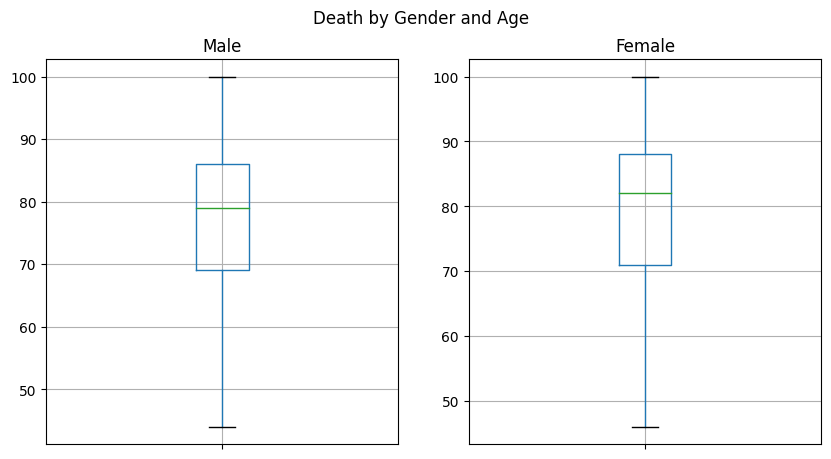

In [3]:
male = data[data['sex_0male_1female'] == 0]
female = data[data['sex_0male_1female'] == 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Patients Dead')

male[male['hospital_outcome_1alive_0dead'] == 0].boxplot(column='age_years', ax=ax1, showfliers=False)
ax1.set_title('Male')
ax1.set_xticklabels([])

female[female['hospital_outcome_1alive_0dead'] == 0].boxplot(column='age_years', ax=ax2, showfliers=False)
ax2.set_title('Female')
ax2.set_xticklabels([])

fig.suptitle("Death by Gender and Age")

plt.show()

In [4]:
num_women = 0
num_men = 0
num_men_survived = 0
num_women_survived = 0

# otwieranie csvki
with open("s41598-020-73558-3_sepsis_survival_primary_cohort.csv", "r") as file:
    reader = csv.reader(file)

    next(reader)

    for row in reader:
        if int(row[1]) == 0:
            num_men += 1
            if int(row[3]) == 1:
                num_men_survived += 1
        else:
            num_women += 1
            if int(row[3]) == 1:
                num_women_survived += 1

# printowanie wynikow
print("Number of women:", num_women)
print("Number of men:", num_men)
print("Number of men who survived:", num_men_survived)
print("Number of women who survived:", num_women_survived)

#epizody sepsy
# read data from the csv file
data = []
with open("s41598-020-73558-3_sepsis_survival_primary_cohort.csv") as f:
    header = f.readline().strip().split(",")
    for line in f:
        parts = line.strip().split(",")
        age_years = int(parts[0])
        sex = int(parts[1])
        episode = int(parts[2])
        outcome = int(parts[3])
        data.append((age_years, sex, episode, outcome))

# liczba obu plci zmarlych na sepse
num_episodes = 4
men_data = [0] * num_episodes
women_data = [0] * num_episodes
for age_years, sex, episode, outcome in data:
    if outcome == 0:
        if episode < num_episodes:
            if sex == 0:
                men_data[episode] += 1
            elif sex == 1:
                women_data[episode] += 1

# printowanie wyników
print("Number of men who died from each episode of sepsis:")
for i, count in enumerate(men_data):
    print("Episode {}: {}".format(i + 1, count))

print("\nNumber of women who died from each episode of sepsis:")
for i, count in enumerate(women_data):
    print("Episode {}: {}".format(i + 1, count))


Number of women: 52231
Number of men: 57973
Number of men who survived: 53425
Number of women who survived: 48674
Number of men who died from each episode of sepsis:
Episode 1: 0
Episode 2: 3320
Episode 3: 838
Episode 4: 242

Number of women who died from each episode of sepsis:
Episode 1: 0
Episode 2: 2744
Episode 3: 565
Episode 4: 165


Na podstawie powyższych danych widzimy ogólne informacje na teamt pacjentów w naszym datasecie. Widzimy informacje o wieku i płci osób które przeżyły. Potem obliczamy ogólne dane i wykluczamy do późniejszych obliczeń epizod 0 sepsy.

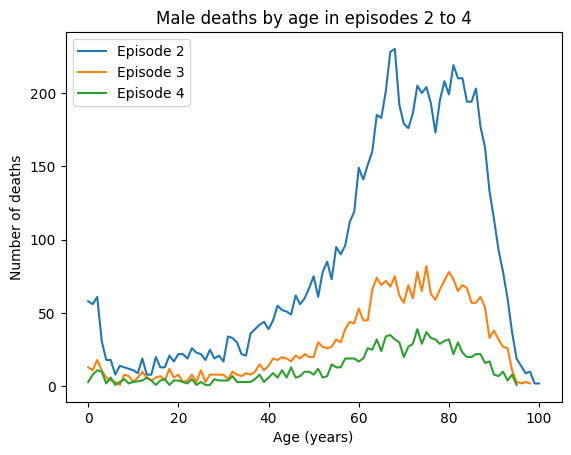

In [5]:
df = pd.read_csv('s41598-020-73558-3_sepsis_survival_primary_cohort.csv')

episodes = [2, 3, 4]

for episode in episodes:
    male_ep_df = df[(df['episode_number'] == episode) & (df['sex_0male_1female'] == 0)]

    deaths_by_age = male_ep_df.groupby('age_years')['hospital_outcome_1alive_0dead'].sum()

    plt.plot(deaths_by_age.index, deaths_by_age.values, label='Episode {}'.format(episode))

plt.xlabel('Age (years)')
plt.ylabel('Number of deaths')
plt.title('Male deaths by age in episodes 2 to 4')
plt.legend()
plt.show()

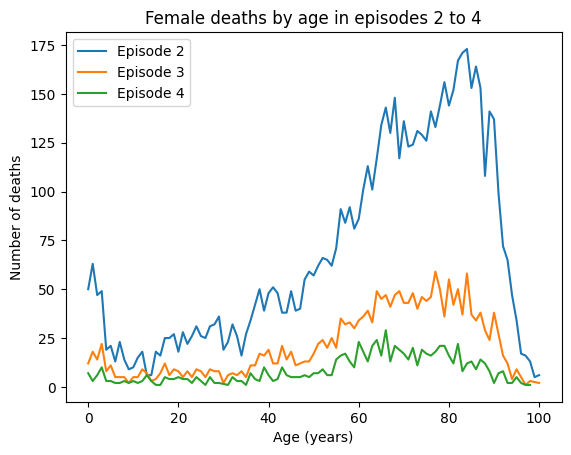

In [6]:
episodes = [2, 3, 4]

for episode in episodes:
    female_ep_df = df[(df['episode_number'] == episode) & (df['sex_0male_1female'] == 1)]

    deaths_by_age = female_ep_df.groupby('age_years')['hospital_outcome_1alive_0dead'].sum()

    plt.plot(deaths_by_age.index, deaths_by_age.values, label='Episode {}'.format(episode))

plt.xlabel('Age (years)')
plt.ylabel('Number of deaths')
plt.title('Female deaths by age in episodes 2 to 4')
plt.legend()
plt.show()

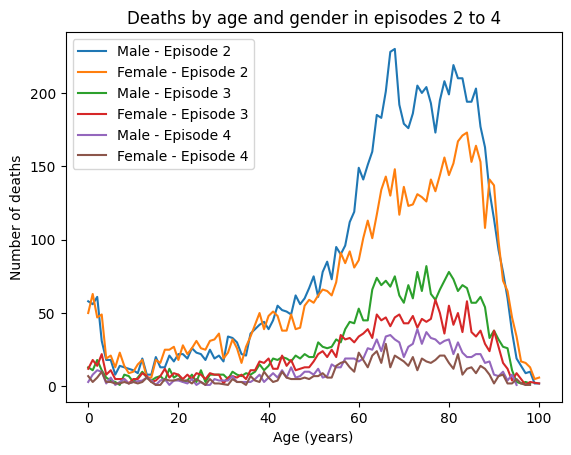

In [7]:
episodes = [2, 3, 4]

for episode in episodes:

    male_ep_df = df[(df['episode_number'] == episode) & (df['sex_0male_1female'] == 0)]
    female_ep_df = df[(df['episode_number'] == episode) & (df['sex_0male_1female'] == 1)]

    male_deaths_by_age = male_ep_df.groupby('age_years')['hospital_outcome_1alive_0dead'].sum()
    female_deaths_by_age = female_ep_df.groupby('age_years')['hospital_outcome_1alive_0dead'].sum()

    plt.plot(male_deaths_by_age.index, male_deaths_by_age.values, label='Male - Episode {}'.format(episode))
    plt.plot(female_deaths_by_age.index, female_deaths_by_age.values, label='Female - Episode {}'.format(episode))

plt.xlabel('Age (years)')
plt.ylabel('Number of deaths')
plt.title('Deaths by age and gender in episodes 2 to 4')
plt.legend()
plt.show()

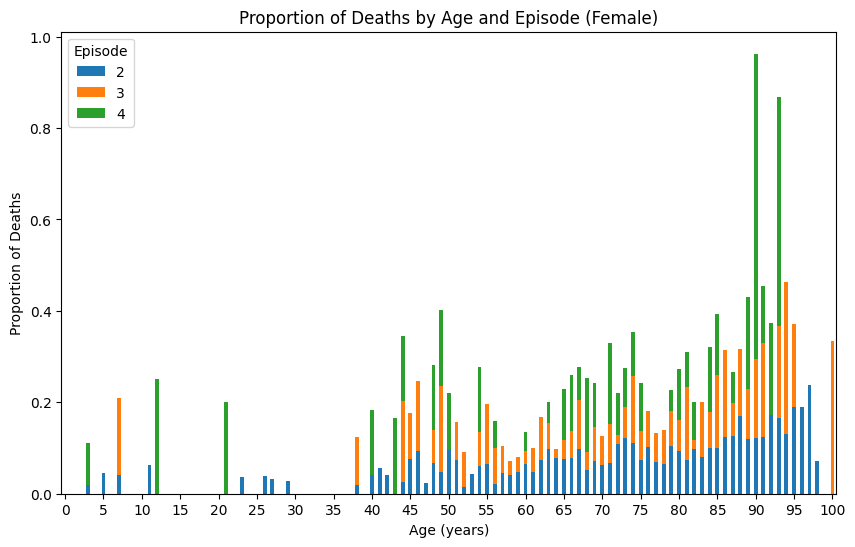

In [9]:
data = pd.DataFrame(data, columns=['age_years', 'sex_0male_1female', 'episode_number', 'hospital_outcome_1alive_0dead'])

female_data = data[data['sex_0male_1female'] == 1]

episode_mask = female_data['episode_number'].isin([2, 3, 4])
female_data = female_data[episode_mask]

grouped = female_data.groupby(['age_years', 'episode_number', 'hospital_outcome_1alive_0dead']).size().unstack()

totals = grouped.sum(axis=1)

proportions = grouped.loc[:, 0] / totals

proportions = proportions.unstack(level=1)

proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xticks(range(0, len(proportions.index), 5), proportions.index[::5], rotation=0)

plt.title('Proportion of Deaths by Age and Episode (Female)')
plt.xlabel('Age (years)')
plt.ylabel('Proportion of Deaths')
plt.legend(title='Episode', loc='upper left')
plt.show()


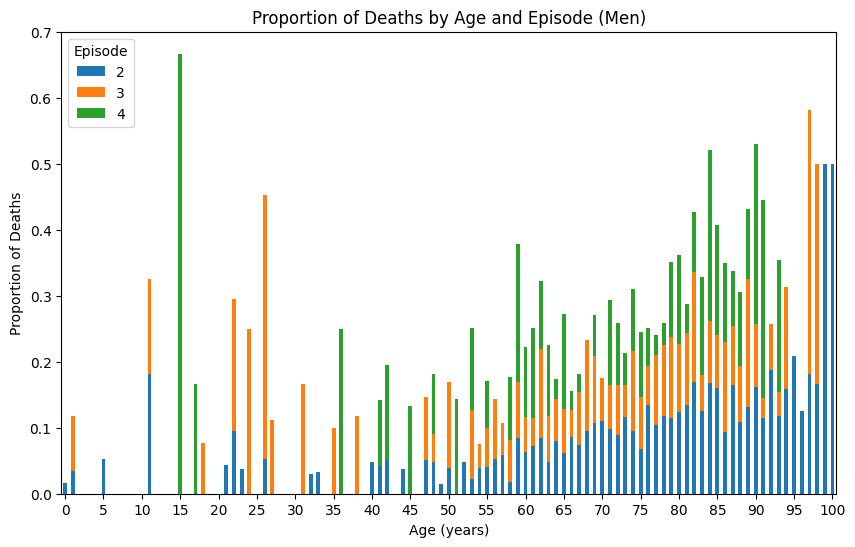

In [10]:
data = pd.DataFrame(data, columns=['age_years', 'sex_0male_1female', 'episode_number', 'hospital_outcome_1alive_0dead'])

male_data = data[data['sex_0male_1female'] == 0]
male_data = male_data[male_data['episode_number'].isin([2, 3, 4])]

grouped = male_data.groupby(['age_years', 'episode_number', 'hospital_outcome_1alive_0dead']).size().unstack()

totals = grouped.sum(axis=1)

proportions = grouped.loc[:, 0] / totals

proportions = proportions.unstack(level=1)

proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xticks(range(0, len(proportions.index), 5), proportions.index[::5], rotation=0)
plt.title('Proportion of Deaths by Age and Episode (Men)')
plt.xlabel('Age (years)')
plt.ylabel('Proportion of Deaths')
plt.legend(title='Episode', loc='upper left')
plt.show()


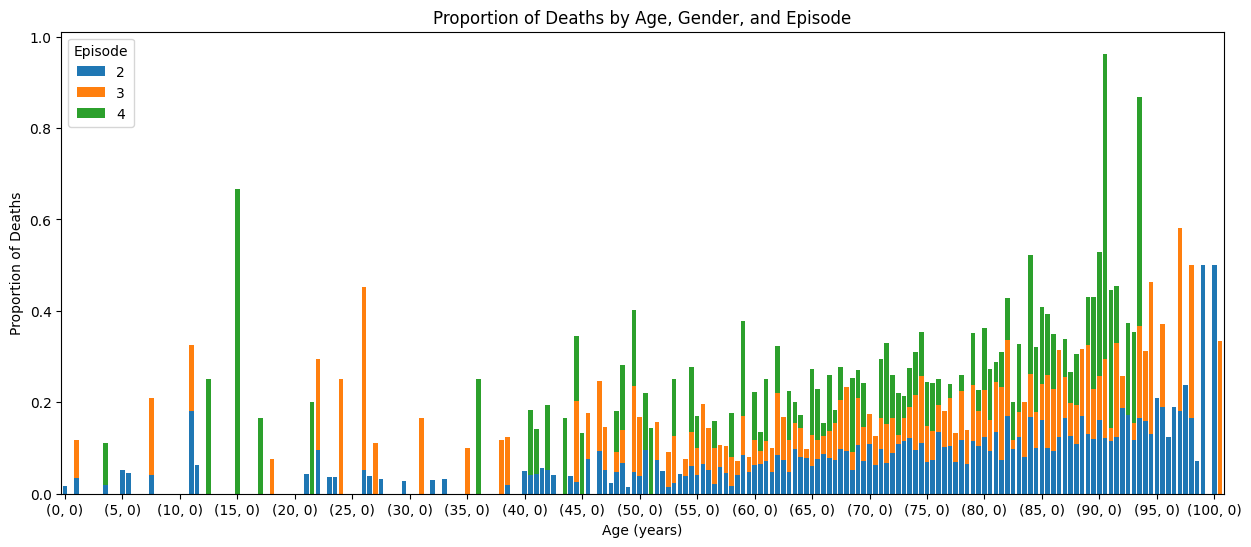

In [14]:
merged_data = pd.concat([male_data, female_data], axis=0)

grouped = merged_data.groupby(['age_years', 'episode_number', 'sex_0male_1female', 'hospital_outcome_1alive_0dead']).size().unstack()

totals = grouped.sum(axis=1)
proportions = grouped.loc[:, 0] / totals
proportions = proportions.unstack(level=1)

proportions.plot(kind='bar', stacked=True, figsize=(15, 6), width=0.8)

plt.xticks(range(0, len(proportions.index)), proportions.index, rotation=0)

plt.title('Proportion of Deaths by Age, Gender, and Episode')
plt.xlabel('Age (years)')
plt.ylabel('Proportion of Deaths')
plt.legend(title='Episode', loc='upper left')
plt.xticks(range(0, len(proportions.index), 10), proportions.index[::10], rotation=0)

plt.show()

Powyższe dane prezentują różne wykresy na temat umierlaności na poszczególne epizody sepsy.

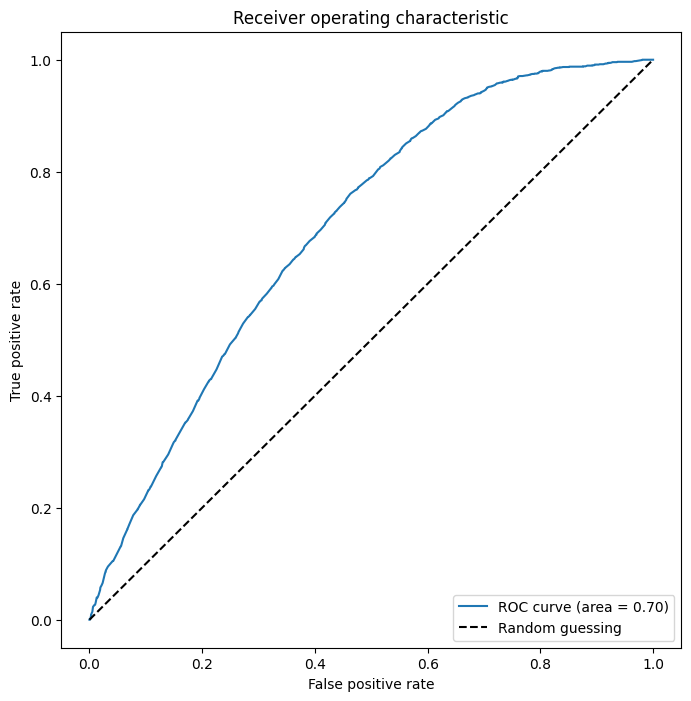

In [12]:
data = pd.read_csv("s41598-020-73558-3_sepsis_survival_primary_cohort.csv")

X = data[['age_years', 'sex_0male_1female', 'episode_number']]

y = data['hospital_outcome_1alive_0dead'].replace({0: 1, 1: 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

Roc curve

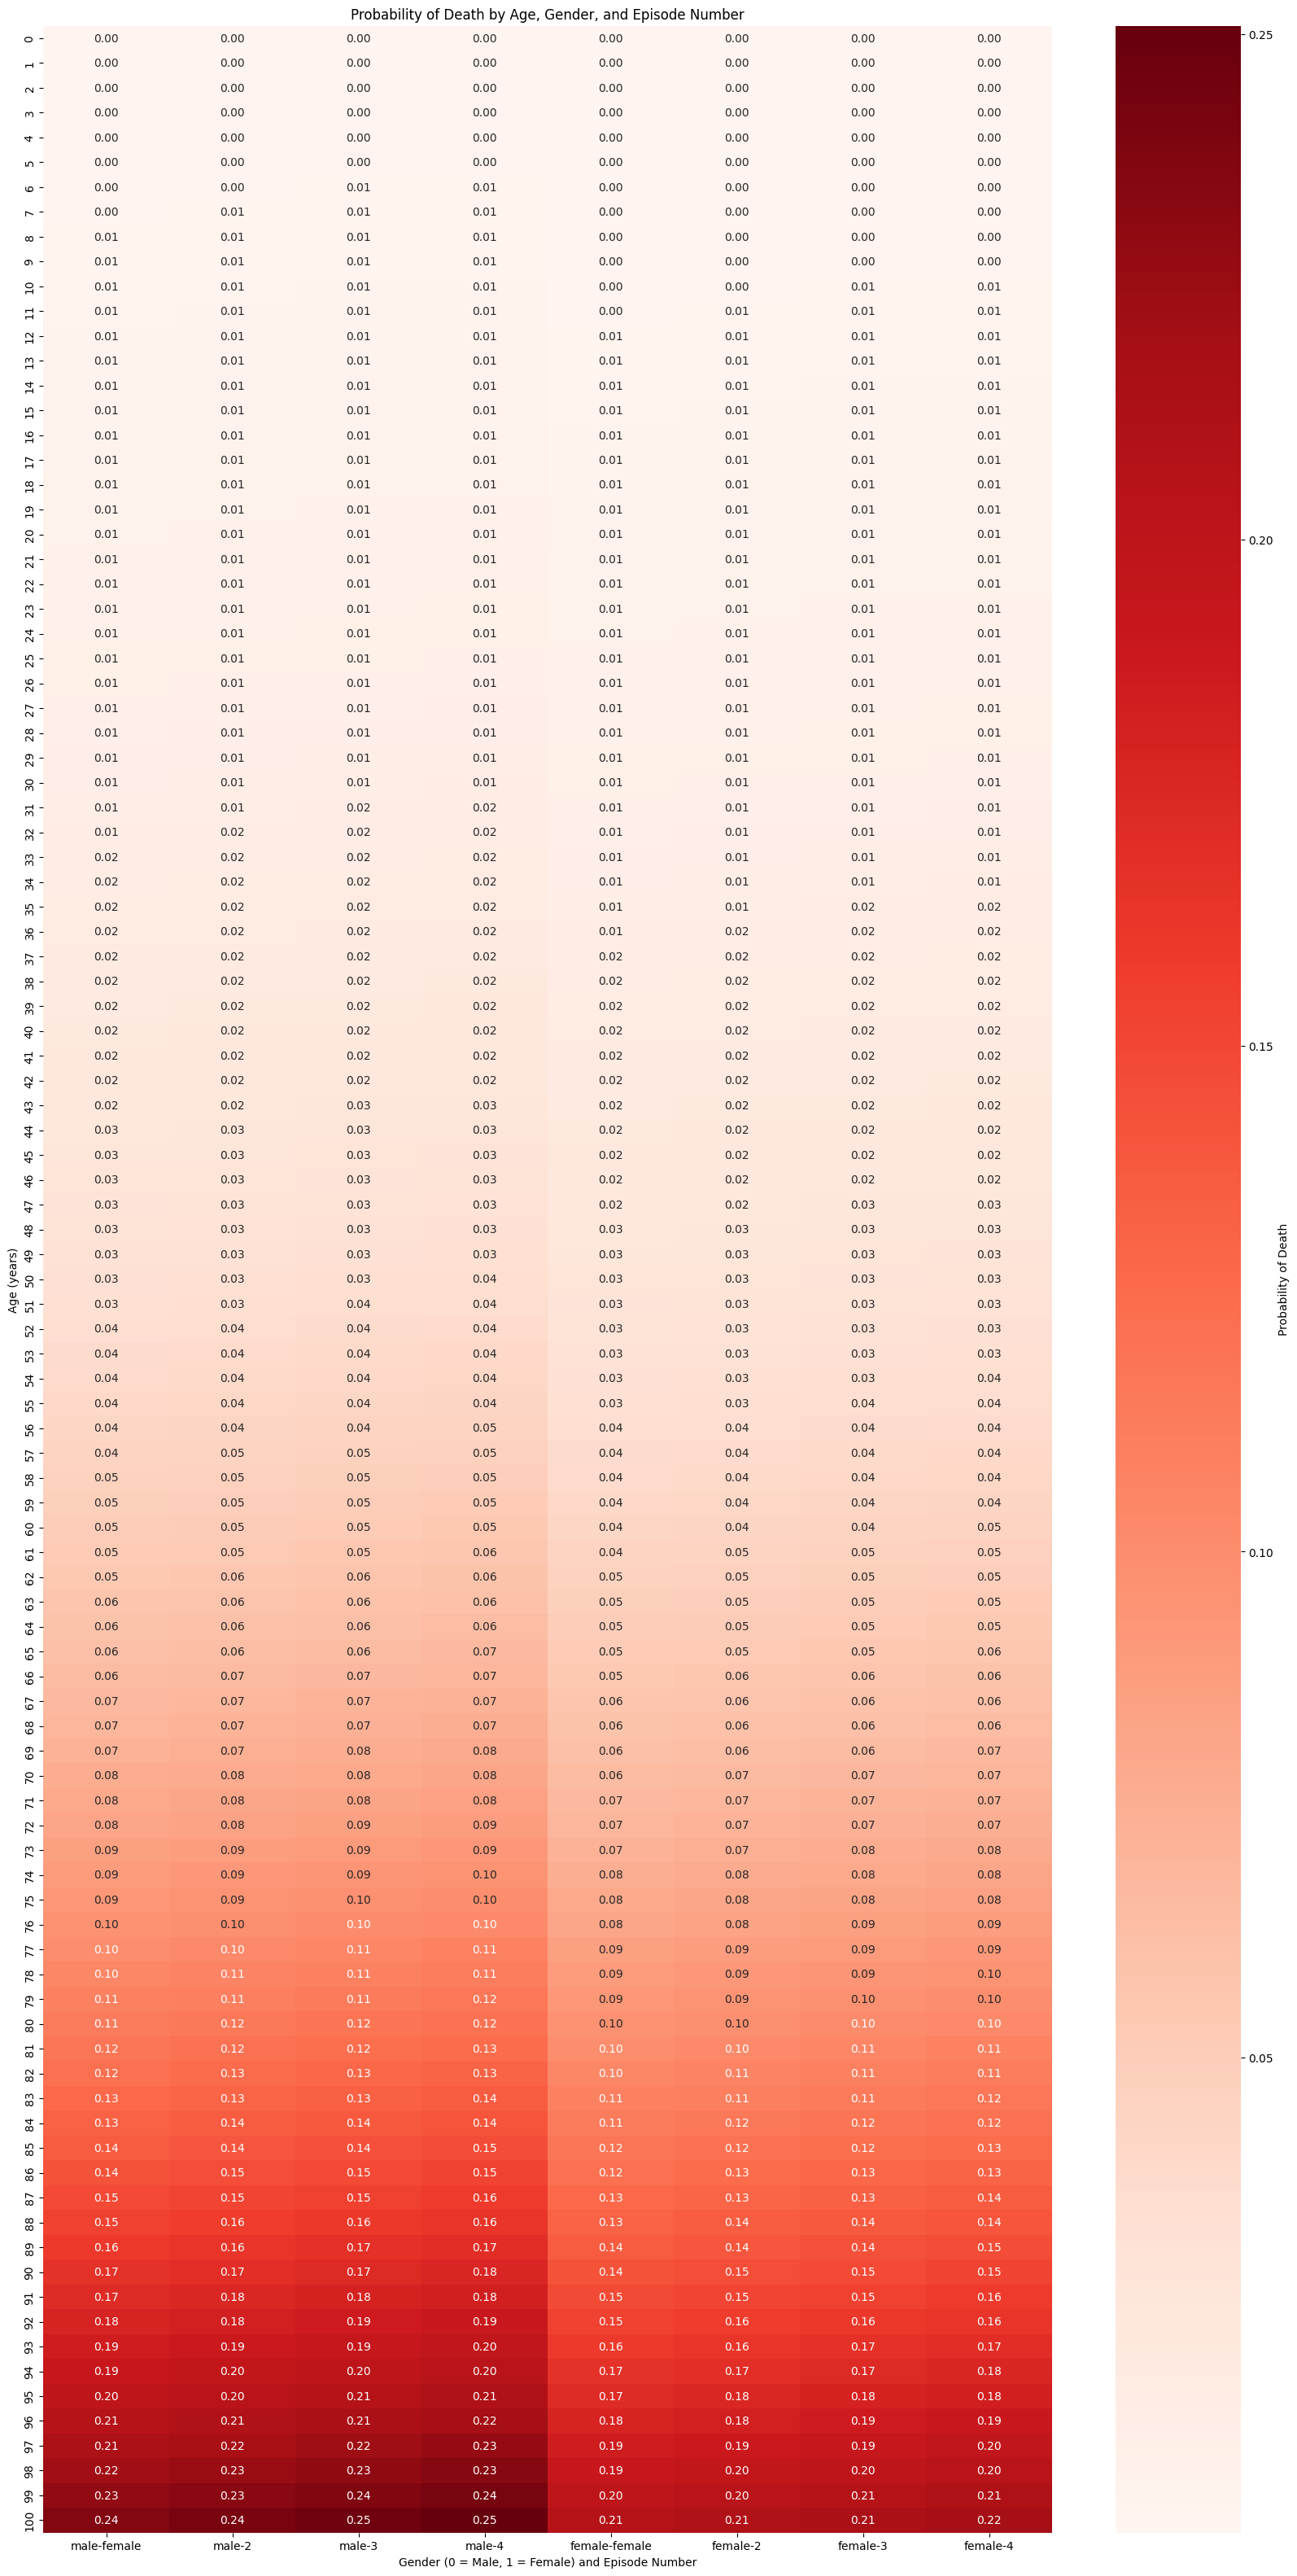

In [13]:
model = LogisticRegression()

model.fit(X, y)

age_range = range(data['age_years'].min(), data['age_years'].max() + 1)
gender_range = [0, 1]
episode_range = range(1, 5)

df = pd.DataFrame([(age, gender, episode) for age in age_range for gender in gender_range for episode in episode_range], columns=['age_years', 'sex_0male_1female', 'episode_number'])

df['death_probability'] = model.predict_proba(df[['age_years', 'sex_0male_1female', 'episode_number']])[:, 1]

pivot = df.pivot_table(index='age_years', columns=['sex_0male_1female', 'episode_number'], values='death_probability')

col_names = {('sex_0male_1female', 0): '', ('sex_0male_1female', 1): '', 0: 'male', 1: 'female'}
pivot = pivot.rename(columns=col_names)

fig, ax = plt.subplots(1, 1, figsize=(20, 40))
ax.set_xticks(range(20, 100, 10))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt='.2f', cbar_kws={'label': 'Probability of Death'})
plt.title('Probability of Death by Age, Gender, and Episode Number')
plt.xlabel('Gender (0 = Male, 1 = Female) and Episode Number')
plt.ylabel('Age (years)')
plt.show()


# Wnioski

Projekt dotyczy datasetu o sepspie który zawiera rekordy o pacjentach ich wieku, płci, epizodzie sepsy oraz czy człowiek umarł czy nie. W swojej pracy skupiam się przedew szystkim na śmierciach i ich przyczynach(tutaj epizodach). Najpierw mamy zrobione box ploty które opisują różne dane o pacjentach u których wykryto sepsę. Możemy z nich odczytać, wszelkie
interesujące nas informacje na temat w jakim wieku jest najwięcej pacjentów co umarli lub przeżeyli, mediane oraz maksymalny
i minimalny wiek. Następnie liczę wszelkie potrzebne informacje do dalszych prac. Zobaczyłem że nie ma pacjentów którzy umarli na 0 epizod sepsy w związku z tym wykluczyłem ten epizod z dalszego modelowania danych. Potem przedstawiam wykresy pokazujące w jakich grupach wiekowych mamy najwięcej śmierci i jakie epizody są najbardziej śmiertelne. Możemy zauważyc że śmiertelność gwałtownie rośnie od 40 do 90 roku zycia dla obu płci a najgroźniejszym epizodem jest epizod drugi. Dużo śmierci jest także w grupie noworodków. Jednak te statystki nie pokazują procentowej umierlanośći a liczbę osób więc nie jesteśmy po tych wykresach stwierdzić do końca jaka grupa i epizod są najgorsze. Dlatego potem przedstawiam wykresy słupkowe już z "procentowymi" wartościami. Widzimy że od 40 roku życia jest wyższa smiertelność jednka nie jest on dużo wyższa od reszty. Potem robimy predykcje dotyczące prawdopodobieństwa śmierci w danym wieku płci oraz epizodzie. Tworzymy krzywą ROC która pokazuje zdolność klasyfikacji binarnej. Wytrenowanie jest wystarczająco dobre do dalszej pracy. Następnie tworzymy "heatmapę" w której pokazujemy grupy najwyższego ryzyka. Możemy wywnioskować ze najwyższą umieralność mają starsi mężczyźni. Widac też niższe prawdopodobieństwo śmierci u kobiet.

Mateusz Orski 235939 inf 5 sem grupa EAIBD